In [5]:
!pip install xgboost


In [6]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [7]:
# Loading dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

In [8]:
# Displaying first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [9]:
# Getting number of rows and columns
data.shape

(19382, 12)

In [10]:
# Getting basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [11]:
# Generating basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [12]:
# Checking for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

Ada sejumlah kecil nilai yang hilang relatif terhadap jumlah sampel dalam himpunan data. Oleh karena itu, pengamatan dengan nilai yang hilang dapat dihilangkan.

In [13]:
# Dropping rows with missing values
data = data.dropna(axis=0)

Tidak ada pengamatan duplikat dalam data.

In [14]:
# Checking class balance
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

Sekitar 50,3% dari kumpulan data mewakili klaim dan 49,7% mewakili opini, sehingga variabel hasil seimbang. Selain itu, model berbasis Pohon kuat terhadap outlier, jadi tidak perlu memperhitungkan atau menjatuhkan nilai apa pun berdasarkan di mana mereka berada dalam distribusinya.

Feature engineering

Sekarang kita mengekstrak panjang (character count) dari setiap video_transcription_text dan menambahkannya ke dataframe sebagai kolom baru yang disebut text_length sehingga dapat digunakan sebagai fitur dalam model.

In [15]:
# Creating `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


calculate the average text_length for claims and opinions 

In [17]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


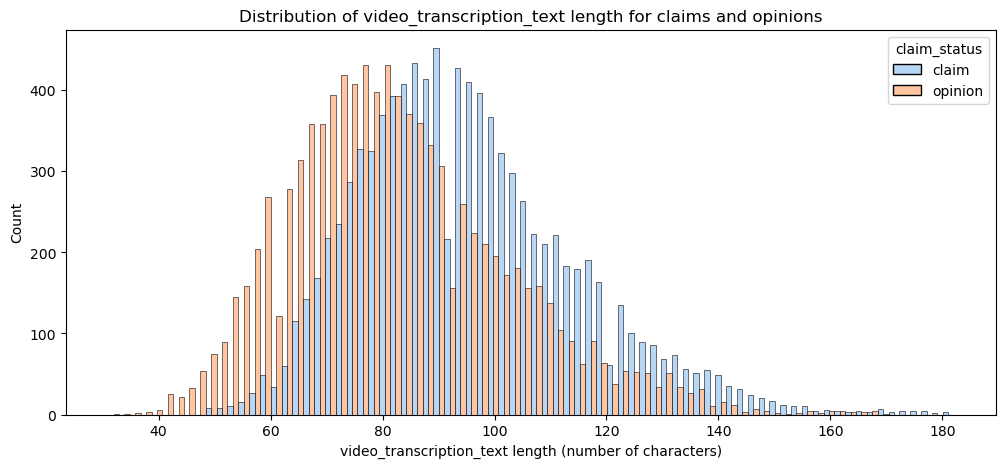

In [18]:
# Visualising the distribution of `text_length` for claims and opinions
# Creating two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Distribusi jumlah huruf untuk klaim dan opini kira-kira normal dengan sedikit kemiringan kanan. Video klaim cenderung memiliki lebih banyak karakter—rata-rata sekitar 13 karakter lebih banyak, seperti yang ditunjukkan di sel sebelumnya.

Feature selection and transformation

In [19]:
X = data.copy()
# Dropping unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encoding target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


Splitting the data

Assigning target variable.
Respons contoh: Dalam hal ini, variabel target adalah claim_status.

0 mewakili opini
1 mewakili klaim

In [20]:
# Isolating target variable
y = X['claim_status']

In [21]:
# Isolating features
X = X.drop(['claim_status'], axis=1)

# Displaying first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


Creating train/validate/test sets

In [22]:
# Splitting the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
# Splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [24]:
# Getting shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

Jumlah fitur (11) selaras antara set pelatihan dan pengujian.
Jumlah baris selaras antara fitur dan variabel hasil untuk pelatihan (11.450) dan validasi dan data pengujian (3.817).

Menandai kolom teks

In [25]:
# Setting up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [26]:
# Extracting numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
# Placing the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Displaying first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# Concatenating `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Displaying first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Selanjutnya, kita mendapatkan jumlah n-gram untuk data validasi. Vectorizer tidak sedang diperbaiki ke data validasi. Itu hanya mengubahnya. Dengan kata lain, transkripsi video dalam data validasi hanya diperiksa terhadap n-gram yang ditemukan dalam data pelatihan.

In [29]:
# Extracting numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
# Placing the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [31]:
# Concatenating `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Displaying first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


 Ulangi proses untuk mendapatkan jumlah N-gram untuk data pengujian.

In [32]:
# Extracting numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Placing the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenating `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Building a random forest model

menyesuaikan model random forest ke set pelatihan. Gunakan validasi silang untuk menyetel hiperparameter dan memilih model yang berkinerja terbaik pada penarikan

In [33]:
# Instantiating the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiating the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [34]:
rf = RandomForestClassifier()

In [35]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20]
}

In [36]:
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=['precision', 'recall', 'f1', 'accuracy'], cv=5, refit='accuracy')

In [37]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 11.5 s, sys: 385 ms, total: 11.9 s
Wall time: 11.9 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [10, 50, 100]},
             refit='accuracy',
             scoring=['precision', 'recall', 'f1', 'accuracy'])

In [38]:
# Examining best recall score
rf_cv.best_score_

0.9973799126637555

In [39]:
# Examining best parameters
rf_cv.best_params_

{'max_depth': 20, 'n_estimators': 50}

Model ini berkinerja sangat baik, dengan skor penarikan rata-rata 0,997 di lima lipatan validasi silang. Setelah memeriksa skor presisi untuk memastikan model tidak mengklasifikasikan semua sampel sebagai klaim, jelas bahwa model ini membuat klasifikasi yang hampir sempurna.

Building an XGBoost model

In [40]:
# Instantiating the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiating the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [41]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)


In [42]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9]
}


In [43]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [44]:
xgb_cv = GridSearchCV(
    estimator=xgb,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,
    refit='recall'  # Refitting the model using the best parameter setting based on 'recall'
)


In [45]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 2min 56s, sys: 40.2 s, total: 3min 37s
Wall time: 28.7 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [46]:
xgb_cv.best_score_

0.9898176171763818

In [47]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

Model ini juga berkinerja sangat baik. Meskipun skor peningatannya sangat sedikit lebih rendah daripada  random forest model's, skor presisinya sempurna.

Evaluating models

Random forest

In [48]:
# Using the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

In [49]:
# Displaying the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [50]:
# Displaying the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

create a confusion matrix to visualize the results of the classification model.

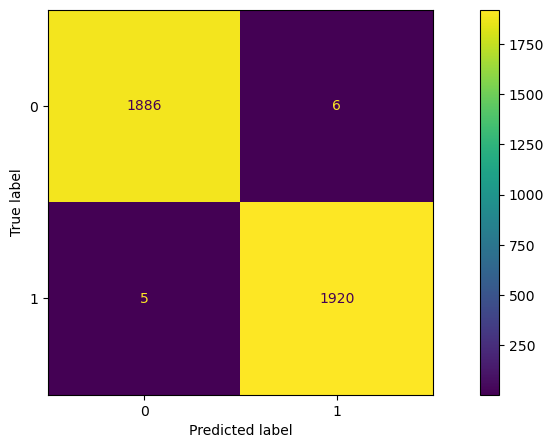

In [51]:
# Creating a confusion matrix to visualise the results of the classification model

# Computing values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.show()

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

In [52]:
# Creating a classification report
# Creating classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications—five false postives and five false negatives.

XGBoost

evaluate the XGBoost model on the validation set.

In [53]:
#Evaluating XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [54]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

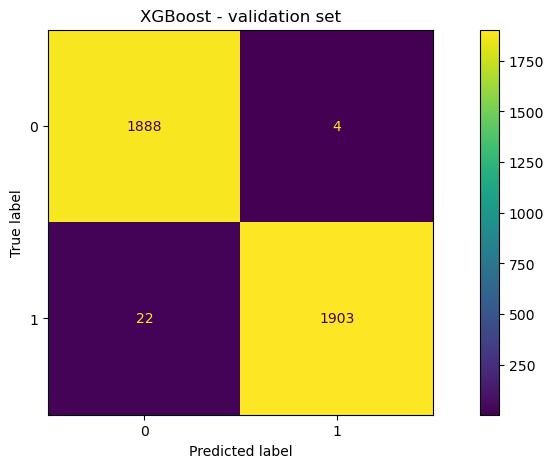

In [55]:
# Computing values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.title('XGBoost - validation set');
plt.show()


In [56]:
# Creating a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



Using champion model to predict on test data

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [57]:
# Using champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

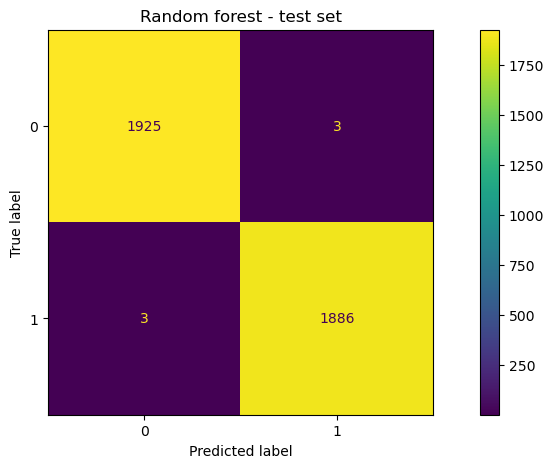

In [58]:
# Computing values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plotting confusion matrix
log_disp.plot()

# Displaying plot
plt.title('Random forest - test set');
plt.show()

In [76]:
# Creating a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.50      0.51      0.50      1892
       claim       0.51      0.50      0.50      1925

    accuracy                           0.50      3817
   macro avg       0.50      0.50      0.50      3817
weighted avg       0.50      0.50      0.50      3817



Berdasarkan accuracy dan F1-Score, model XGBoost menunjukkan performa yang jauh lebih baik dibandingkan dengan model Random Forest, namun XGBoost kesalahannya cenderung negatif palsu.

XGBoost memiliki accuracy sebesar 99%

Random Forest hanya memiliki accuracy sebesar 50%.

Precision, Recall, dan F1-Score pada model XGBoost semuanya berada di kisaran 0.99-1.00, sementara pada model Random Forest nilai-nilai tersebut berada di 0.50, yang menunjukkan model ini bekerja kurang baik.


Mengidentifikasi klaim adalah prioritas utama, jadi penting bagi model ini untuk menangkap semua video klaim yang sebenarnya. Model random forest memiliki skor recall yang lebih baik, maka random forest adalah model yang terbaik

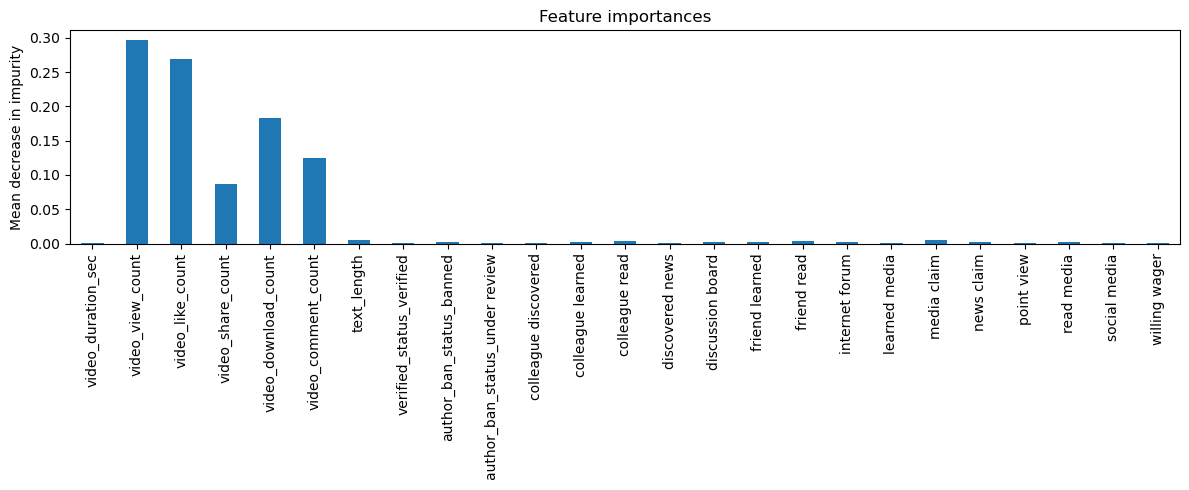

In [78]:
#Feature importances of champion model
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

Hasil dari kesimpulan EDA Fitur yang paling prediktif semuanya terkait dengan tingkat keterlibatan yang dihasilkan oleh video

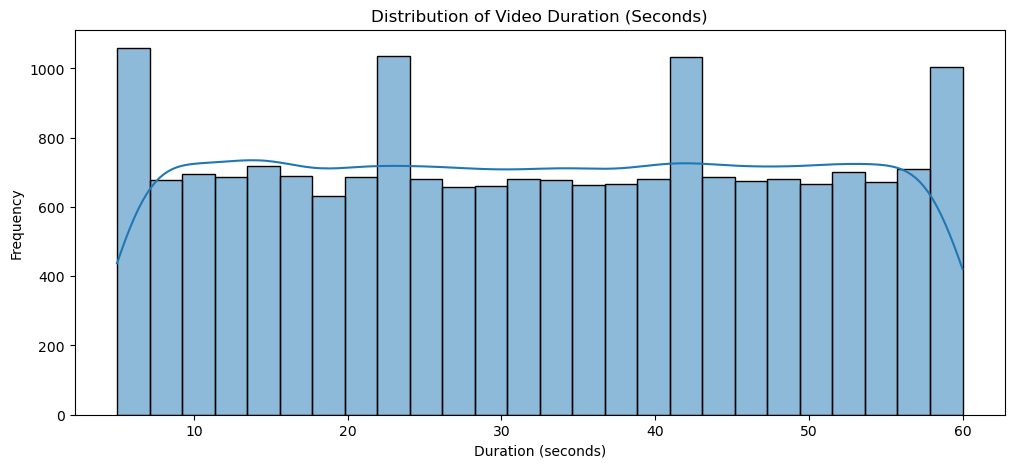

In [61]:
#Distribusi durasi video

sns.histplot(data['video_duration_sec'], kde=True)
plt.title('Distribution of Video Duration (Seconds)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

⁠Distribusi Durasi Video (Detik)

Analisis: 

Grafik distribusi durasi video menunjukkan bahwa durasi video TikTok terdistribusi secara cukup merata di berbagai durasi, dengan beberapa lonjakan di sekitar 10 detik, 30 detik, dan mendekati 60 detik.


Insight:

Lonjakan pada durasi 10, 30, dan 60 detik mungkin menunjukkan bahwa konten kreator sering menggunakan durasi video yang lebih singkat, terutama di sekitar durasi umum (seperti 10, 30, atau 60 detik), yang mungkin sesuai dengan batasan durasi standar TikTok atau pola preferensi pengguna.


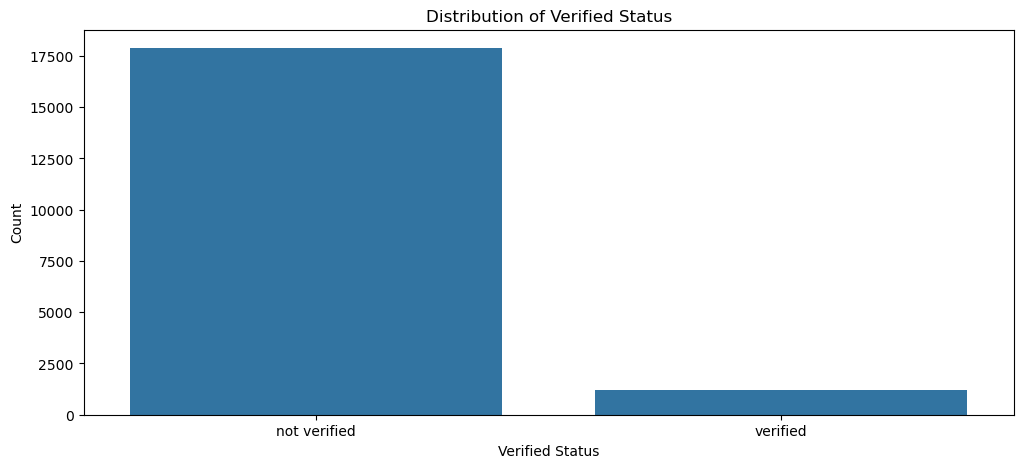

In [63]:
#status verifikasi penulis
sns.countplot(data=data, x='verified_status')
plt.title('Distribution of Verified Status')
plt.xlabel('Verified Status')
plt.ylabel('Count')
plt.show()

Distribusi Status Verifikasi


Analisis:

Dari grafik ini, terlihat bahwa mayoritas besar pengguna tidak terverifikasi, sementara hanya sebagian kecil yang memiliki status terverifikasi.


Insight:

Status verifikasi adalah fitur langka di TikTok, yang mungkin hanya diperoleh oleh akun-akun dengan pengaruh besar atau publik figur. Ini bisa jadi faktor yang berpengaruh dalam hal engagement dan popularitas video.


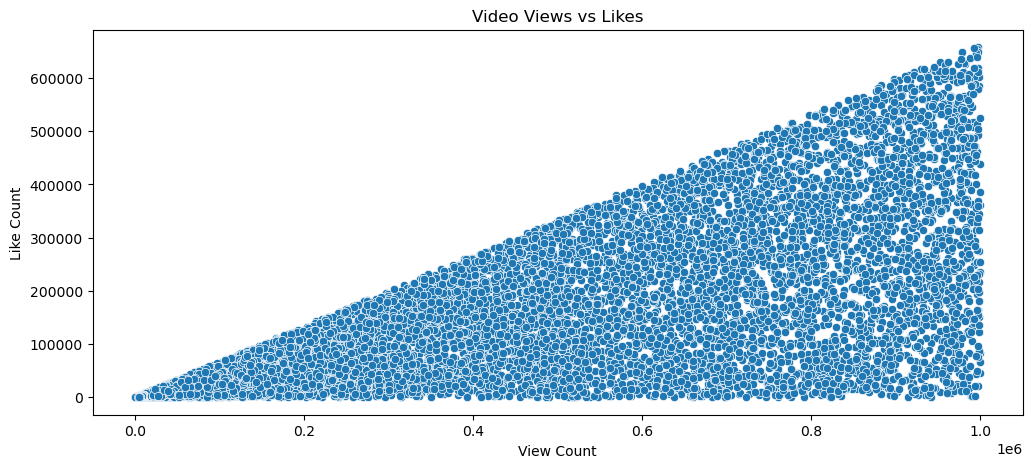

In [65]:
#jumlah views vs likes
sns.scatterplot(data=data, x='video_view_count', y='video_like_count')
plt.title('Video Views vs Likes')
plt.xlabel('View Count')
plt.ylabel('Like Count')
plt.show()

Hubungan Antara Jumlah View dan Like


Analisis: 

Scatter plot menunjukkan hubungan linier positif yang jelas antara jumlah views dan likes, artinya semakin banyak views yang didapatkan oleh suatu video, semakin besar pula jumlah like yang diterima.


Insight: 

Hubungan yang erat antara views dan likes ini menunjukkan bahwa video yang dilihat lebih banyak cenderung mendapatkan like yang lebih banyak. Hal ini bisa diantisipasi karena view adalah prasyarat untuk like. Namun, tidak semua video dengan view tinggi mendapatkan proporsi like yang sama.


Kesimpulan Umum:


Video dengan durasi tertentu (10 detik, 30 detik, 60 detik) tampaknya lebih populer atau sering diunggah, yang bisa mengindikasikan bahwa pengguna TikTok menyukai konten singkat dan padat.
Akun yang tidak terverifikasi jauh lebih banyak, tetapi akun terverifikasi mungkin memberikan kontribusi lebih besar pada video dengan engagement yang lebih tinggi.
Ada korelasi positif yang kuat antara jumlah views dan likes, yang menunjukkan bahwa engagement (like) umumnya mengikuti jumlah view, tetapi beberapa video bisa lebih efektif dalam mengkonversi views menjadi likes dibandingkan yang lain.